📊 UserSec Threat Data Analysis

In [ ]:
# 1. 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config import collection  # 우리가 만든 config.py에서 DB 연결 가져오기

# 2. 몽고DB에서 모든 데이터 가져오기
print("데이터를 불러오는 중입니다...")
data = list(collection.find({}, {"_id": 0})) # _id는 필요 없어서 제외

# 3. 판다스 데이터프레임으로 변환
df = pd.DataFrame(data)

# 4. 데이터 잘 가져왔는지 상위 5개만 확인
print(f"총 수집된 메시지 수: {len(df)}개")
df.head()

데이터를 불러오는 중입니다...
총 수집된 메시지 수: 47개


,channel_name,message_id,crawled_at,date,forward_from,is_forwarded,text,text_translated,url,views
0,usersecc,627,2025-12-25 08:55:55.079,2025-12-24 15:59:59,None,False,⚠️ Объявляем о том что скоро начнутся новогодн...,⚠️ 모든 [**교육**](https://t.me/usersecc/607)**에 대...,https://t.me/usersecc/627,3036
1,usersecc,626,2025-12-25 08:55:56.333,2025-12-24 12:24:06,None,False,**3-я часть по Deutsche Telekom в ближайшие 24...,**앞으로 24시간 동안 Deutsche Telekom에서 3부 방송이 제공됩니다.**,https://t.me/usersecc/626,759
2,usersecc,624,2025-12-25 08:55:57.360,2025-12-23 21:48:19,PeerChannel(channel_id=2292107603),True,Одно место занято. Еще один хейтер может расчи...,한자리가 꽉 차있습니다. 또 다른 증오자는 침대에 의지할 수 있어,https://t.me/usersecc/624,779
3,usersecc,623,2025-12-25 08:55:58.392,2025-12-23 21:48:19,PeerChannel(channel_id=2292107603),True,Могу взять с собой несколько хейтеров геев. Ба...,게이 싫어하는 사람 몇 명 데리고 갈 수 있어요. 트렁크가 비어 있습니다.,https://t.me/usersecc/623,777
4,usersecc,622,2025-12-25 08:55:59.582,2025-12-23 21:48:19,PeerChannel(channel_id=2292107603),True,Еду в мск,나는 모스크바 시간에 갈거야,https://t.me/usersecc/622,757


## 1. Daily Activity Trend

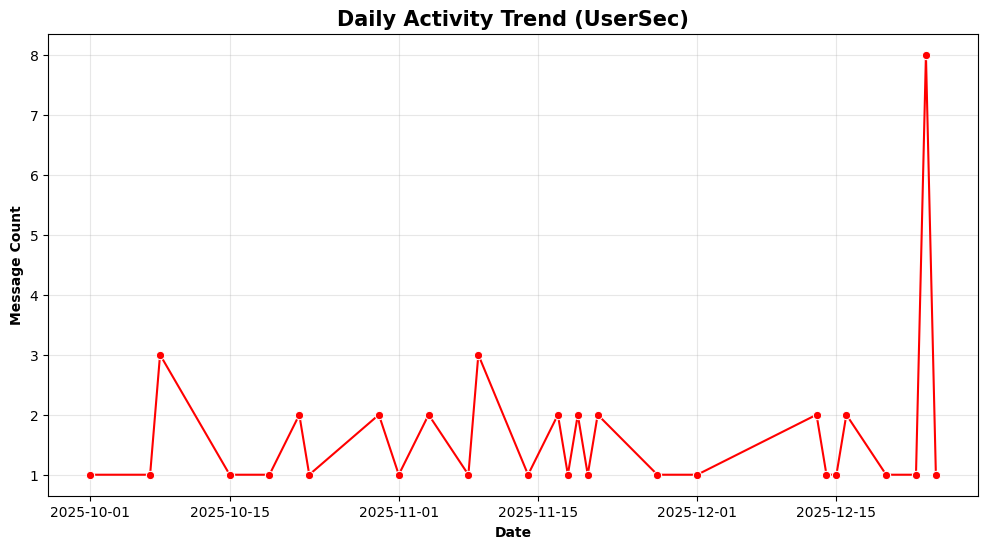

In [42]:
# 1. 날짜 데이터 전처리 (Timezone 변환)
# 몽고DB의 date 컬럼을 datetime 객체로 변환
df['date'] = pd.to_datetime(df['date'])

# UTC 시간을 동호주 시간(AEST)으로 변환 (+10시간)
df['date_aest'] = df['date'] + pd.Timedelta(hours=10)

# 2. '날짜(YYYY-MM-DD)'만 추출해서 카운팅
daily_counts = df['date_aest'].dt.date.value_counts().sort_index()

# 3. 그래프 그리기
plt.figure(figsize=(12, 6)) # 그래프 크기 설정
sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker='o', color='red')

plt.title('Daily Activity Trend (UserSec)', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Message Count', fontweight='bold')
plt.grid(True, alpha=0.3)
#plt.xticks(rotation=45) # 날짜 겹치지 않게 기울이기

plt.show()

## 2. Activity Time Analysis (MSK vs UTC)

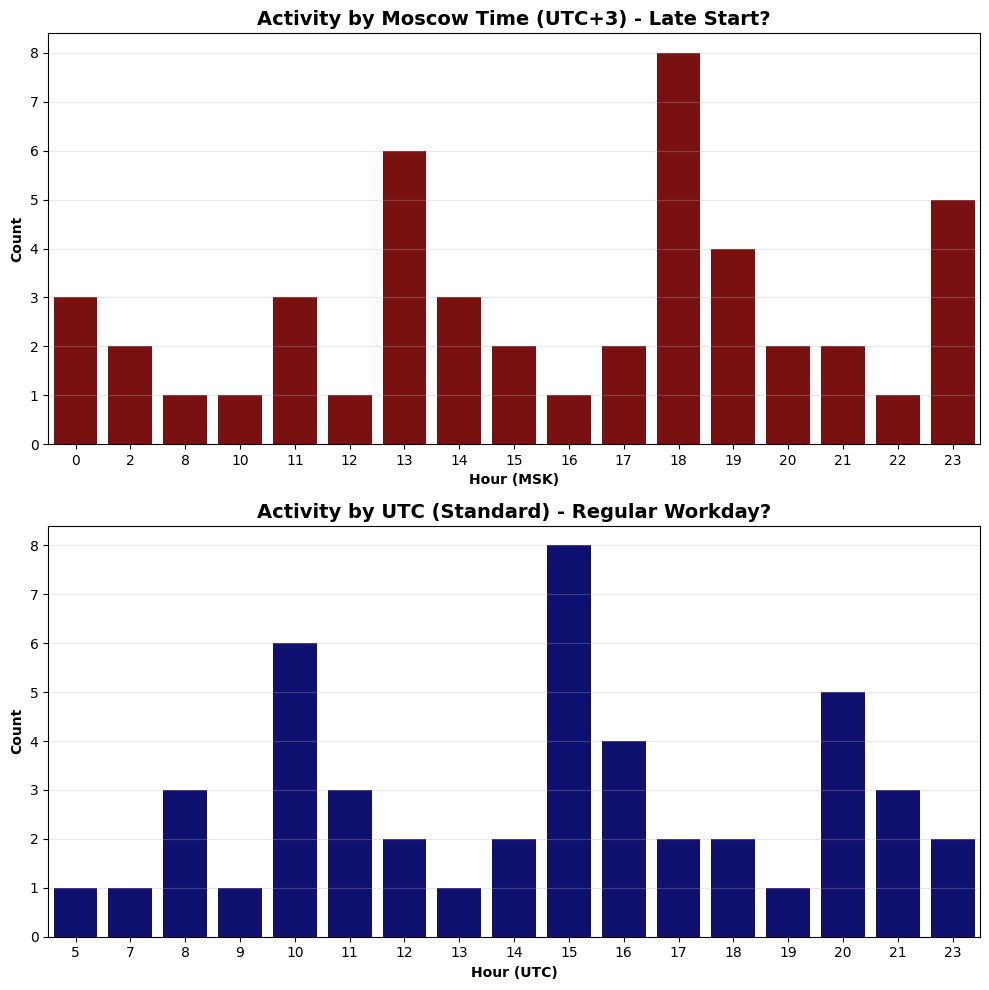

In [43]:
# 데이터 준비
df['hour_msk'] = (df['date'] + pd.Timedelta(hours=3)).dt.hour  # 모스크바
df['hour_utc'] = df['date'].dt.hour                            # UTC (표준)

# 그래프 그리기 (두 개를 위아래로 비교)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# 1. 모스크바 시간 기준
sns.countplot(x='hour_msk', data=df, ax=axes[0], color='darkred')
axes[0].set_title('Activity by Moscow Time (UTC+3) - Late Start?', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour (MSK)', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 2. UTC 시간 기준
sns.countplot(x='hour_utc', data=df, ax=axes[1], color='navy')
axes[1].set_title('Activity by UTC (Standard) - Regular Workday?', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour (UTC)', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Threat Topic Analysis

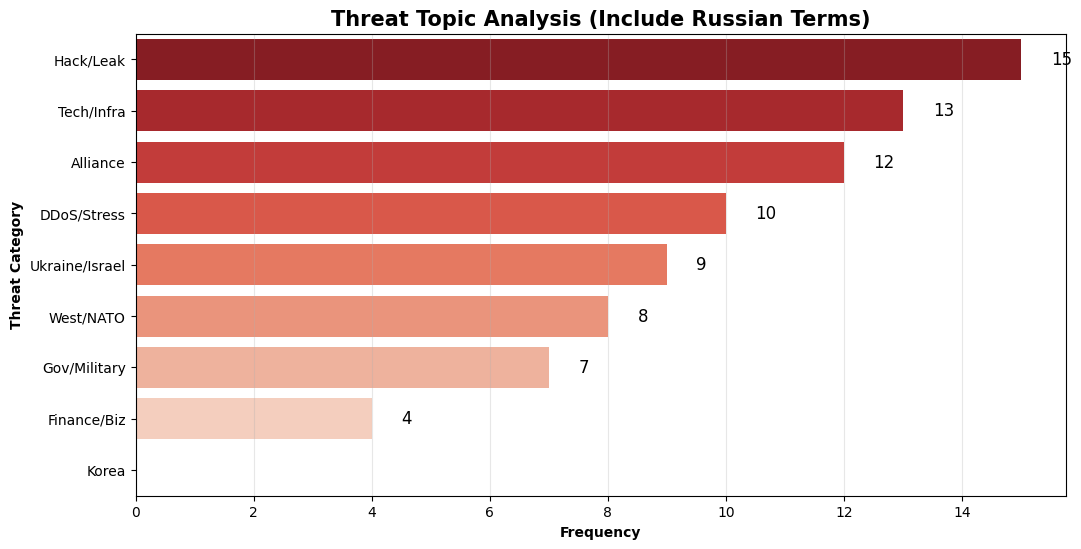

In [ ]:
# 1. 감시할 키워드 사전 정의 (어근 검색 최적화 반영)
keyword_map = {
    # Category: [English, Russian]
    # 1. 공격 유형 (Method)
    'DDoS/Stress': ['ddos', 'ддос', 'attack', 'атак', 'kill', 'stress', 'down', 'упал', 'лежит', 'ложи'],
    'Hack/Leak': ['hack', 'взлом', 'leak', 'слив', 'data', 'данн', 'access', 'доступ', 'deface'],    
    
    # 2. 기술 스택 (Tech & Infra)
    'Tech/Infra': ['rtsp', 'vnc', 'cctv', 'cam', 'server', 'сервер', 'unix', 'linux', 'bot', 'бот'],
    
    # 3. 공격 타겟 - 국가 (Geopolitics)
    'Korea': ['korea', 'коре', 'kr', 'seoul', 'сеул', 'kisa'],
    'West/NATO': ['usa', 'сша', 'nato', 'нато', 'eu', 'europe', 'german', 'немец', 'deutsc'],
    'Ukraine/Israel': ['ukrain', 'украин', 'israel', 'израил'], # 주요 분쟁국
    
    # 4. 공격 타겟 - 섹터 (Sector)
    'Gov/Military': ['gov', 'правительств', 'militar', 'army', 'военн', 'mfa'],
    'Finance/Biz': ['bank', 'банк', 'money', 'pay', 'plat', 'плат', 'swift', 'bitcoin', 'биткоин'],
    
    # 5. 연대/동맹 (Alliance)
    'Alliance': ['killnet', 'килнет', 'anonymous', 'legion', 'revil', 'usersec']
}

# 2. 카운팅 로직 (대소문자 무시)
counts = {}
for category, words in keyword_map.items():
    # 여러 단어 중 하나라도 포함되면 카운트 (OR 조건)
    pattern = '|'.join(words) 
    counts[category] = df['text'].str.contains(pattern, case=False, regex=True).sum()

# 3. 데이터프레임 변환 및 정렬
kw_df = pd.DataFrame(list(counts.items()), columns=['Category', 'Count'])
kw_df = kw_df.sort_values(by='Count', ascending=False)

# 4. 막대 그래프 그리기
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=kw_df,
                 hue='Category', palette='Reds_r', legend=False)

plt.title('Threat Topic Analysis (Include Russian Terms)', fontsize=15, fontweight='bold')
plt.xlabel('Frequency', fontweight='bold')
plt.ylabel('Threat Category', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# 막대 옆에 숫자 표시
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 0.5,    # x 좌표 (막대 끝에서 약간 오른쪽)
                p.get_y() + p.get_height() / 2, # y 좌표 (막대 중간)
                f'{int(width)}', 
                ha='left', va='center', fontsize=12, color='black')

plt.show()

## 4. Threat Keyword Frequency

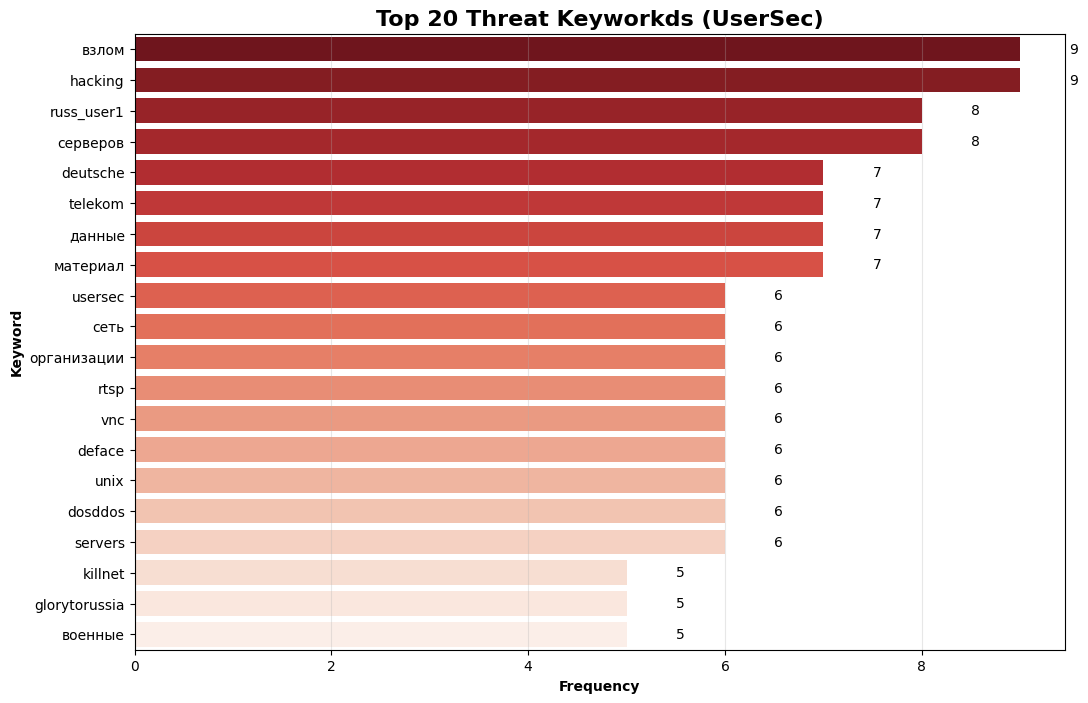

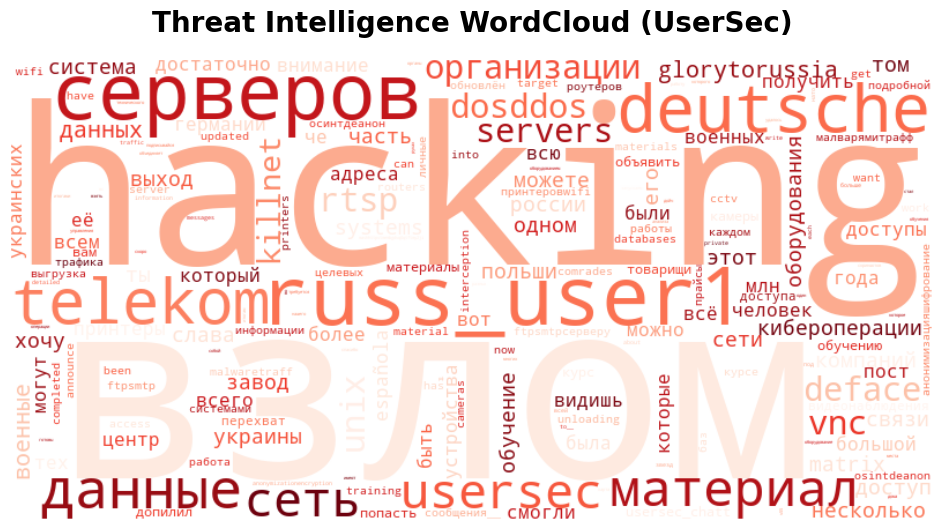

In [ ]:
from collections import Counter
import re
from wordcloud import WordCloud

# 1. 불용어(Stopwords) 정의: 기본 + CTI 노이즈 + 스팸성 문구
stop_words = set([
    # English
    'the', 'an', 'in', 'on', 'at', 'to', 'of', 'and', 'or', 'is', 'are', 'was', 'were',
    'for', 'with', 'by', 'from', 'it', 'this', 'that', 'you', 'we', 'our', 'us', 'me',
    'http', 'https', 'course', 'channel', 'group', 'join', 'subscribe', 'click',
    # Russian
    'в', 'на', 'не', 'что', 'по', 'из', 'за', 'от', 'для', 'но', 'мы', 'вы', 'они', 'он', 'она',
    'это', 'нас', 'нам', 'их', 'них', 'как', 'так', 'же', 'или', 'если', 'то', 'все', 'было',
    'есть', 'будет', 'только', 'где', 'когда', 'уже', 'мне', 'тебе', 'себе', 'наше',
    'место', 'время', 'теперь', 'писать', 'канал', 'группа', 'привет', 'подпишись', 'ссылка'
])

# 2. 텍스트 정제 및 단어 추출 함수
def clean_and_tokenize(text):
    if not isinstance(text, str): return []

    # 특수문자 제거
    text = re.sub(r'[^\w\s]', '', text).lower() 
    words = text.split()
    
    cleaned_words = []
    for w in words:
        # 필터링 로직
        if (w not in stop_words and 
            len(w) > 1 and 
            not w.startswith('-') and 
            not w.startswith('_') and 
            not w.isdigit()):            
            cleaned_words.append(w)
            
    return cleaned_words

# 3. 전체 데이터에서 단어 모으기
all_words = []
for text in df['text']:
    all_words.extend(clean_and_tokenize(text))

# 4. 빈도수 계산 (전체 & 상위 20개)
all_counts = Counter(all_words)
top_20 = all_counts.most_common(20)

# 5. [시각화 1] 막대 그래프
top_df = pd.DataFrame(top_20, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Frequency', y='Word', data=top_df,
                 hue='Word', palette='Reds_r', legend=False)

plt.title('Top 20 Threat Keyworkds (UserSec)', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontweight='bold')
plt.ylabel('Keyword', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# 숫자 표시
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height()/2, 
            f'{int(width)}', va='center', fontsize=10)
    
plt.show()

# 6. [시각화 2] 워드 클라우드
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='Reds',
    font_path=None,
    stopwords=stop_words # 불용어 리스트 적용
).generate_from_frequencies(all_counts) # 전체 데이터

# 7. 그림 그리기
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # x, y축 눈금 끄기
plt.title('Threat Intelligence WordCloud (UserSec)', fontsize=20, fontweight='bold', pad=20)

plt.show()